<a href="https://colab.research.google.com/github/KBerry-050/data-science-portfolio/blob/main/Module_6_Assignment_Berry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries for EDA and visualization
import pandas as pd
import numpy as np
from numpy import mean, absolute, sqrt, arange
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# INGEST

In [ ]:
# INGEST TRAIN AND TEST DATASETS
train = pd.read_csv('train.csv')
train = pd.DataFrame(train)

test = pd.read_csv('test.csv')
test = pd.DataFrame(test)

In [ ]:
# explore train data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# check for null values
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [ ]:
# identify explanatory and response variables
x = train.drop(['label'], axis = 1)
y = train['label']

# normalize image data for pixel values
x /= 255
holdout = test/255

# MODELING

In [ ]:
# import libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import datetime

In [ ]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
# create function for cross val scoring
def cross_val(model, x_train, y_train):
    start = datetime.datetime.now()
    kfold = StratifiedKFold(n_splits=7,shuffle=True)
    cv = cross_val_score(model, x_train, y_train, cv=kfold)
    end = datetime.datetime.now()
    print(f'Cross Val Score: {cv.mean().round(3)} ± {cv.std().round(3)} // Time: {end-start}')

In [ ]:
# create function for model fitting
def model_fit(model, x_train, y_train, x_test, y_test):
    start = datetime.datetime.now()
    model.fit(x_train, y_train)
    end = datetime.datetime.now()
    print(f'OOB Score: {model.oob_score_}')
    print(f'Test Score: {model.score(x_test, y_test)}')
    print(f'Training Time: {end-start}')
    return model

In [ ]:
# create random forest classifier model
rf = RandomForestClassifier(oob_score=True, n_estimators=100)
cross_val(rf, x_train, y_train)

Cross Val Score: 0.962 ± 0.002 // Time: 0:01:39.619164


In [ ]:
# fit rf model
rf = model_fit(rf, x_train, y_train, x_test, y_test)

OOB Score: 0.9596428571428571
Test Score: 0.9646428571428571
Training Time: 0:00:16.617528


In [ ]:
# make predictions on test dataset
rf_pred = rf.predict(x_test)
rf_pred = pd.DataFrame(rf_pred, columns=['Predictions'])
rf_pred["Target"] = list(y_test)

In [ ]:
# specify targets and create a classification report
targets = ['0','1','2','3','4','5','6','7','8','9',]
print(classification_report(rf_pred['Target'], rf_pred['Predictions'], target_names=targets))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       818
           1       0.98      0.99      0.98       897
           2       0.97      0.97      0.97       839
           3       0.96      0.95      0.95       826
           4       0.95      0.97      0.96       812
           5       0.98      0.95      0.97       783
           6       0.97      0.97      0.97       847
           7       0.97      0.97      0.97       864
           8       0.95      0.96      0.96       832
           9       0.94      0.93      0.94       882

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [ ]:
# export csv of predictions
rf_pred = rf.predict(holdout)
rf_pred = pd.Series(rf_pred, name="Label")

digit_recognizer_rf = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), rf_pred], axis=1)
digit_recognizer_rf['ImageId'] = digit_recognizer_rf['ImageId']+1
digit_recognizer_rf.to_csv(r'/Users/kyleberry/Documents/MSDS-422/Module 6/Module 6 Assignment/digit_recognizer_rf.csv', index=False)

In [ ]:
# perform PCA on train dataset
pca = PCA()
pca = pca.fit(x_train)

In [ ]:
# set variance threshold - need to represent 95% of the variability
variance = pca.explained_variance_ratio_
cum_variance = np.cumsum(variance)
num_components = np.argmax(cum_variance >= .95) +1

Text(0.5, 1.0, 'Component vs Cumulative Variance Explained')

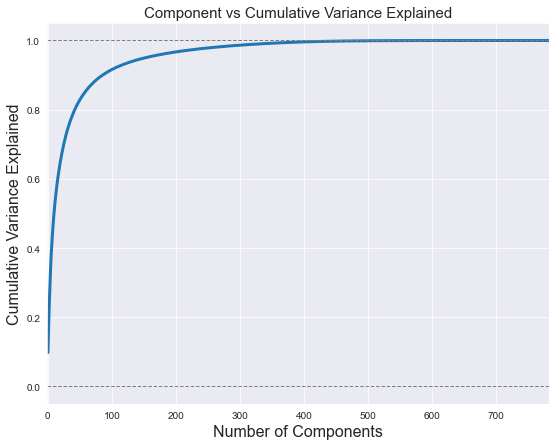

In [ ]:
# plot variance
plt.figure(figsize=(9,7))

component_number = range(len(cum_variance))
plt.plot(component_number, cum_variance, lw=3)

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,len(cum_variance)])
ax.set_ylim([-0.05,1.05])
ax.set_ylabel('Cumulative Variance Explained', fontsize=16)
ax.set_xlabel('Number of Components', fontsize=16)
ax.set_title('Component vs Cumulative Variance Explained', fontsize=15)

In [ ]:
# apply PCA to a new train and test set
pca = PCA(n_components = num_components)
z_train = pca.fit_transform(x_train)
z_test = pca.transform(x_test)

In [ ]:
# check shape
z_train.shape

(33600, 153)

In [ ]:
# create new RF model and perform cross validation
rf_pca = RandomForestClassifier(oob_score=True, n_estimators=100)
cross_val(rf_pca, z_train, y_train)

Cross Val Score: 0.939 ± 0.004 // Time: 0:03:25.961434


In [ ]:
# fit the new model
rf_pca = model_fit(rf_pca, z_train, y_train, z_test, y_test)

OOB Score: 0.9269642857142857
Test Score: 0.9419047619047619
Training Time: 0:00:35.230495


In [ ]:
# make new predictions
rf_pca_train = rf_pca.predict(z_test)
rf_pca_train_df = pd.DataFrame(rf_pca_train, columns=['Predictions'])
rf_pca_train_df["Target"] = list(y_test)

In [ ]:
# create classification report
print(classification_report(rf_pca_train_df['Target'], rf_pca_train_df['Predictions'], target_names=targets))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       818
           1       0.97      0.99      0.98       897
           2       0.94      0.93      0.93       839
           3       0.91      0.92      0.91       826
           4       0.93      0.95      0.94       812
           5       0.94      0.93      0.93       783
           6       0.97      0.97      0.97       847
           7       0.95      0.95      0.95       864
           8       0.93      0.91      0.92       832
           9       0.92      0.90      0.91       882

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [ ]:
# export csv of predictions
pca_test = pca.transform(holdout)
rf_pca_pred = rf_pca.predict(pca_test)
rf_pca_pred = pd.Series(rf_pca_pred, name="Label")

digit_recognizer_rf_pca = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), rf_pca_pred], axis=1)
digit_recognizer_rf_pca['ImageId'] = digit_recognizer_rf_pca['ImageId']+1
digit_recognizer_rf_pca.to_csv(r'/Users/kyleberry/Documents/MSDS-422/Module 6/Module 6 Assignment/digit_recognizer_rf_pca.csv', index=False)

In [ ]:
# k-means clustering

# create function to map cluster to labels
def get_reference_dict(clusters, data_label):
    reference_label = {}
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

In [ ]:
# create function to map predictions to labels
def get_labels(clusters, reference_labels):
    number_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        number_labels[i] = reference_labels[clusters[i]]
    return number_labels

In [ ]:
# start with 10 clusters
n = len(y.unique())
kmeans = KMeans(n_clusters=n)
kmeans.fit(x)
clusters = kmeans.predict(x)

In [ ]:
# get referenace labels and accuracy score
reference_labels = get_reference_dict(clusters,y)
predicted_labels = get_labels(clusters, reference_labels)
print(reference_labels)
print(accuracy_score(predicted_labels, y))

{0: 4, 1: 6, 2: 7, 3: 8, 4: 3, 5: 0, 6: 1, 7: 1, 8: 0, 9: 2}
0.5908571428571429


In [ ]:
# check inertia to see how well the dataset was clustered
print(f'Inertia: {kmeans.inertia_}')

Inertia: 1648241.4467875406


In [ ]:
# create confusion matrix
cm = confusion_matrix(y, predicted_labels)
cm_df = pd.DataFrame(cm, columns= ["Predicted 0","Predicted 1","Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7", "Predicted 8","Predicted 9"],
                    index = ["Actual 0","Actual 1","Actual 2","Actual 3","Actual 4","Actual 5","Actual 6","Actual 7","Actual 8","Actual 9"])
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,3695,12,9,139,24,0,129,8,116,0
Actual 1,0,4656,3,4,4,0,5,4,8,0
Actual 2,77,526,2914,232,126,0,141,49,112,0
Actual 3,98,353,150,2800,121,0,43,33,753,0
Actual 4,17,312,27,0,2277,0,130,1296,13,0
Actual 5,219,676,12,1268,239,0,72,246,1063,0
Actual 6,177,360,49,19,55,0,3413,2,62,0
Actual 7,18,425,31,4,1304,0,5,2607,7,0
Actual 8,52,465,35,768,127,0,35,127,2454,0
Actual 9,49,234,6,51,2110,0,12,1675,51,0


In [ ]:
# export predictions to csv
km_test_preds = kmeans.predict(holdout)
test_predicted_labels = get_labels(km_test_preds, reference_labels)
test_predicted_labels = np.array([int(x) for x in test_predicted_labels])

km_preds = pd.Series(test_predicted_labels, name="Label")
digit_recognizer_km = pd.concat([pd.Series(range(len(holdout)), name="ImageId"), km_preds], axis=1)
digit_recognizer_km['ImageId'] = digit_recognizer_km['ImageId'] +1
digit_recognizer_km.to_csv(r'/Users/kyleberry/Documents/MSDS-422/Module 6/Module 6 Assignment/digit_recognizer_km.csv', index=False)

In [ ]:
# increase number of clusters
km2 = MiniBatchKMeans(n_clusters=30)
km2.fit(x)
clusters2 = km2.predict(x)

In [ ]:
# make dictionary and check accuracy
reference_labels2 = get_reference_dict(clusters2, y)
predicted_labels2 = get_labels(clusters2, reference_labels2)
print(reference_labels2)
print(accuracy_score(predicted_labels2, y))

{0: 4, 1: 1, 2: 9, 3: 0, 4: 4, 5: 5, 6: 6, 7: 3, 8: 5, 9: 0, 10: 1, 11: 5, 12: 6, 13: 9, 14: 3, 15: 7, 16: 2, 17: 6, 18: 0, 19: 6, 20: 8, 21: 8, 22: 6, 23: 7, 24: 2, 25: 7, 26: 3, 27: 2, 28: 0, 29: 4}
0.763547619047619


In [ ]:
print(f'Inertia: {km2.inertia_}')

Inertia: 1405783.3959919969


In [ ]:
cm2 = confusion_matrix(y, predicted_labels2)
cm_df2 = pd.DataFrame(cm2, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
                     index = ["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
cm_df2

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,3616,0,6,62,5,154,268,2,18,1
Actual 1,0,4514,12,99,1,32,7,9,10,0
Actual 2,51,119,3518,150,71,50,32,84,101,1
Actual 3,23,31,115,3038,11,466,26,52,552,37
Actual 4,4,62,15,40,2471,53,116,282,2,1027
Actual 5,33,25,1,891,51,2471,92,20,173,38
Actual 6,35,39,1,105,11,68,3871,0,7,0
Actual 7,5,142,45,32,148,41,6,3659,9,314
Actual 8,41,108,28,590,65,287,20,73,2809,42
Actual 9,17,46,6,86,948,34,18,900,31,2102


In [ ]:
# export predictions to csv
km_test_preds2 = km2.predict(holdout)
test_predicted_labels2 = get_labels(km_test_preds2, reference_labels2)
test_predicted_labels2 = np.array([int(x) for x in test_predicted_labels2])

km_preds2 = pd.Series(test_predicted_labels2, name="Label")
digit_recognizer_km2 = pd.concat([pd.Series(range(len(holdout)), name="ImageId"), km_preds2], axis=1)
digit_recognizer_km2['ImageId'] = digit_recognizer_km2['ImageId'] +1
digit_recognizer_km2.to_csv(r'/Users/kyleberry/Documents/MSDS-422/Module 6/Module 6 Assignment/digit_recognizer_km2.csv', index=False)

# CONCLUSION

The first Random Forest model that I created was the most accurate, close to 97%. After doing some principal component analysis with a new model, I created another Random Forest  with 94% accuracy. Missing pixel data might be to blame here, which could mess with identifying digits that look pretty similar. Lastly, I created a K-Means clustering model and after an initial try with 10 clusters, I increased that to 30 and found another good model with roughly 97% accuracy.